In [1]:
import pandas as pd
import numpy as np
import tarfile
import io
import os

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split
from skimage import io
import PIL
import torch

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, ToPILImage, Normalize, Compose
import torch.nn.functional as F
from IPython.display import display

# PyTorch libraries and modules
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.optim as optim

from timeit import default_timer as timer

In [2]:
test_folder = '/home/doshi.mee/csye7105_project/dataset/SPR X-Ray Images/kaggle/kaggle/test/'
train_folder = '/home/doshi.mee/csye7105_project/dataset/SPR X-Ray Images/kaggle/kaggle/train/'

train_age_csv = '/home/doshi.mee/csye7105_project/dataset/SPR X-Ray Images/train_age.csv'
train_gender_csv = '/home/doshi.mee/csye7105_project/dataset/SPR X-Ray Images/train_gender.csv'

resize_value = 128
batch_size = 128
epochs = 6

In [3]:
class XRayTrain(Dataset):
    def __init__(self, csv_file, img_dir, transform = None):
        self.img_dir = img_dir
        self.annotations = pd.read_csv(csv_file, nrows = 10702, dtype = {'imageId': str})
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, f"{self.annotations.iloc[index, 0]}.png")
        img = Image.open(img_path)
        img = img.resize((resize_value, resize_value))
        img = Image.fromarray(255 - np.array(img))
        y_label = torch.tensor(int (self.annotations.iloc[index, 1]))

        if self.transform:
            img = self.transform(img)

        return (img, y_label)

In [4]:
# Creating tensors for the images and their labels for age
train_a_data = XRayTrain(csv_file = train_age_csv, img_dir = train_folder,
                       transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                                        transforms.Resize((resize_value, resize_value)),
                                                        transforms.ToTensor()]))
train_size = int(0.8 * len(train_a_data))
test_size = len(train_a_data) - train_size

train_age_data, test_age_data = torch.utils.data.random_split(train_a_data, [train_size, test_size])

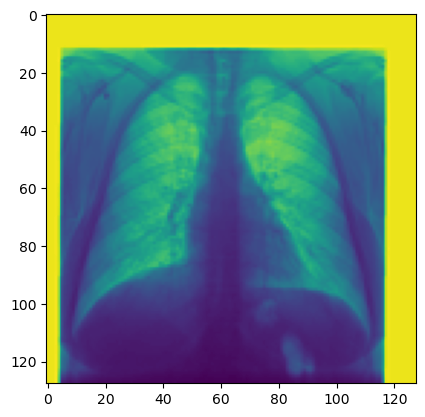

In [5]:
# To check if images are stored correctly
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

for i in range(len(test_age_data)):
    img, label = test_age_data[i]
    img = img.permute(1,2,0)
    imshow(img)
    if i == 4:
        break

In [6]:
# loading the data
train_age_loader = DataLoader(dataset = train_age_data, batch_size = batch_size, shuffle = True, pin_memory = True)
test_age_loader = DataLoader(dataset = test_age_data, batch_size = batch_size, shuffle = True, pin_memory = True)

In [7]:
# Creating the Gender Model
class AgeModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = (3, 3), stride = 1, padding = 1)
        self.batch1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = (3, 3), stride = 1, padding = 1)
        self.batch2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.batch3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)
        self.batch4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 1024)
        self.drop1 = nn.Dropout(p = 0.4)
        self.fc2 = nn.Linear(1024, 128)
        self.drop2 = nn.Dropout(p = 0.5)
        self.fc3 = nn.Linear(128, 128)

    def forward(self,x):
        x = self.pool1(F.relu(self.batch1((self.conv1(x)))))
        x = self.pool2(F.relu(self.batch2((self.conv2(x)))))
        x = self.pool3(F.relu(self.batch3((self.conv3(x)))))
        x = self.pool4(F.relu(self.batch4((self.conv4(x)))))
        x = x.view(-1, 128 * 8 * 8)
        x = self.drop1(x)
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [8]:
CUDA_LAUNCH_BLOCKING =1
torch.cuda.empty_cache()
gpus = torch.cuda.device_count()

model1 = AgeModel()
if gpus >= 1:
    print("Let's use", gpus, "GPUs!")
    model = nn.DataParallel(model1)

device = torch.device("cuda")
model.to(device)

Let's use 1 GPUs!


DataParallel(
  (module): AgeModel(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [9]:
def train(): 
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)   
    criterion = nn.CrossEntropyLoss()
    
    n_samples = 10240
    total_loss = 0
    total_train = 0
    correct_train = 0.0
    
    for i, (img, labels) in enumerate(train_age_loader):
        img = img.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss = total_loss + loss.item()
        
        #accuracy
        _, predicted = torch.max(output.data, 1)
        predicted = predicted
        total_train += labels.size(0)
        correct_train += predicted.eq(labels.data).sum().item()
        train_accuracy = 100 * correct_train / total_train
        
    losses.append(loss.item())
    train_acy.append(train_accuracy)
    return (train_accuracy, loss.item())

In [10]:
def valid(epochs):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        
        with torch.no_grad():
            for i, (img, labels) in enumerate(test_age_loader):
                img = img.to(device)
                labels = labels.to(device)
                outputs = model(img)
                _, predicted = torch.max(outputs.data, 1)
                predicted = predicted
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                acc = 100 * correct / total
                
    valid_acy.append(acc)
    return acc

In [11]:
def predict(img_test_dir):
    model1 = torch.load('/home/doshi.mee/csye7105_project/age_model_dp.pt')
    img = Image.open(img_test_dir)
    
    with torch.no_grad():
        trans1 = transforms.Compose([transforms.Grayscale(num_output_channels = 1),
                                                        transforms.Resize((resize_value, resize_value)),
                                                        transforms.ToTensor(),
                                                        transforms.Normalize(mean = [0.5], std = [0.5])])
        img_tensor = trans1(img)
        
        single_image_batch = img_tensor.unsqueeze(0)
        outputs = model1(single_image_batch)
        _, predicted = torch.max(outputs.data, 1)
        age_id = predicted[0].item()
        
        print("Predicted Age : {}".format(age_id))
        display(img.resize((256, 256)))

Training for 6 epochs
Inside Validation
Epoch 0, train Loss: 4.543 Training Accuracy 1.4717906786590351: Valid Accuracy 1.8215787015413358
GPU time:  494.9976511260029
Inside Validation
Epoch 1, train Loss: 4.224 Training Accuracy 2.347856558813223: Valid Accuracy 2.1485287248949088
GPU time:  436.74890474718995
Inside Validation
Epoch 2, train Loss: 4.198 Training Accuracy 2.5230697348440603: Valid Accuracy 2.335357309668379
GPU time:  416.88003138802014
Inside Validation
Epoch 3, train Loss: 4.177 Training Accuracy 2.8501343301016235: Valid Accuracy 2.6156001868285848
GPU time:  400.37389499205165
Inside Validation
Epoch 4, train Loss: 4.133 Training Accuracy 3.317369466183857: Valid Accuracy 2.70901447921532
GPU time:  387.7718434911221
Inside Validation
Epoch 5, train Loss: 4.175 Training Accuracy 3.36409297979208: Valid Accuracy 2.8491359177954227
GPU time:  405.18651935993694
Model successfully saved
Time taken for 6 epochs is 2542.257974466076 seconds


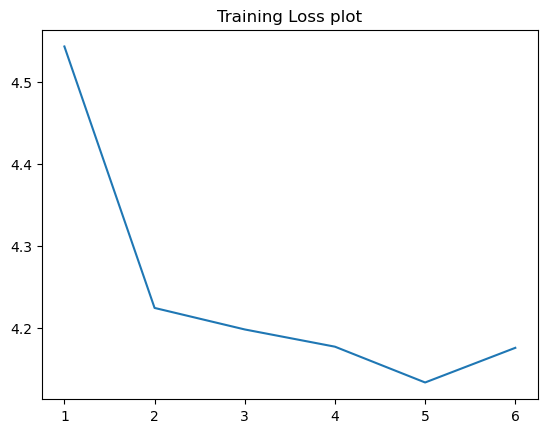

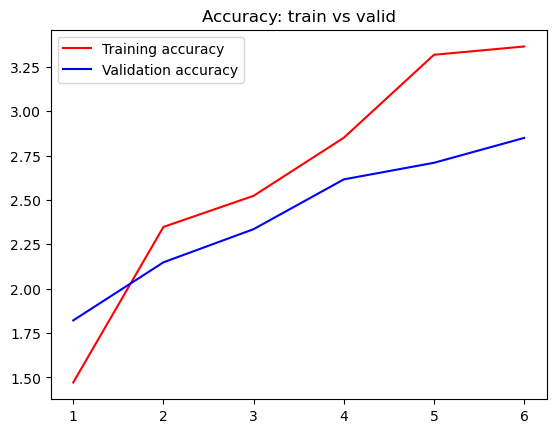

In [12]:
import sys
import argparse

print("Training for {} epochs".format(epochs))

main_time = timer()
losses = []
train_acy = []
valid_acy = []

for epoch in range(epochs):
    start = timer()
    (train_acc, loss_tr) = train()
    valid_acc = valid(epochs)
    
    print('Epoch {}, train Loss: {:.3f}'.format(epoch ,loss_tr), 'Training Accuracy {}:' .format(train_acc), 'Valid Accuracy {}'.format(valid_acc))
    print("GPU time: ", timer() - start)

folder = '/home/doshi.mee/csye7105_project'
torch.save(model, f"{folder}/age_model_dp.pt")
print("Model successfully saved")
torch.cuda.empty_cache()

print("Time taken for", epochs, "epochs is", timer() - main_time, "seconds")

epoch = range(1, len(losses) + 1)
plt.title("Training Loss plot")
plt.plot(epoch, losses)

plt.figure()
plt.title("Accuracy: train vs valid")
plt.plot(epoch, train_acy, 'red', label = 'Training accuracy')
plt.plot(epoch, valid_acy, 'blue', label = 'Validation accuracy')
plt.legend()
plt.show()

Predicted Age : 66


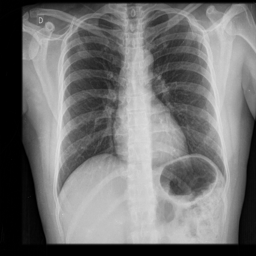

In [16]:
predict(f"{train_folder}000207.png")